## Image Preprocessing Pipeline for my Own Handwritten Digits


In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

datapath = 'own_hand_data/'
d = 1 # digit displayed in this notebook

/home/adrian/anaconda2/envs/deep/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def show_image(image):
    #image = observation[0].reshape(28, 28)
    #print observation[0].shape, image.shape    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=matplotlib.cm.Greys)

### Preprocessing
 - Read all the images into a dictionary
 - Convert to white ink on black background.
 - Scale the image down to 28x28 pixels, by cropping black edges, resizing to 20x20 and padding up with black to 28x28.
 - Center the digit by shifting the inner box to the center of mass (transformation matrix )


In [3]:
from PIL import Image

def get_image(filepath):
    """
    Image can be in gif jpeg or png format.
    """
    
    """
    When a picture is taller than it is wide, it means the camera was rotated. 
    Some cameras can detect this and write that info in the picture's EXIF metadata. 
    Some viewers take note of this metadata and display the image appropriately.

    PIL can read the picture's metadata, but it does not write/copy metadata when you save an Image. 
    Consequently, your smart image viewer will not rotate the image as it did before.
    
    The call to rotate(-90) degrees will reset this artifact 
    
    """
    with Image.open(filepath) as im:
        im = im.rotate(-90, expand=True)
        pixel_values = np.asarray(im)
        
    img = Image.fromarray(pixel_values)
    return img

In [4]:
import os
import re

def get_filenames(path, pattern):
    filenames = []
    for f in os.listdir(path):
        if re.search(pattern, f):
            filenames.append(f)
    return filenames


def get_images(datapath):
    digits = {}

    for fn in get_filenames(datapath, '^\d\.JPG'):
        dig = int(fn.split('.')[0])
        digits[dig] = get_image(datapath+fn)
    
    return digits

In [5]:
import PIL.ImageOps    

def to_bw(im):
    """
    convert the image to black & white
    """
    
    im = im.convert('L')          # from color to black & white
    im = PIL.ImageOps.invert(im)  # negate
    
    return im

If you look closely, these images have noise, these are grey digits on a gray background and not sharp black & white like the MNIST training set images.

Therefore we need to add the following:

In [6]:
def gray_threshold(image):
    bw = np.asarray(image).copy()
    # Pixel range is 0...255, 256/2 = 128
    bw[bw < 128] = 0    # Black
    bw[bw >= 128] = 255 # White
    return Image.fromarray(bw)

In [7]:
def v(x): return int(np.round(np.mean(x))) 

def trim_border(image):
    """
    remove every row and column at the sides of the image which are completely black, 
    leaving a margin of 30 pix to avoid truncation in the scaling step that comes after this.
    """
    m = 1  # margin
    # assumes background coded as 0 and ink as 255
    
    img = np.asarray(image)
    
    # remove first row and column: (fixes a bug in the image)
    img = img[1:]
    img = np.delete(img,0,1)
    
    #print np.sum(img[30]), v(img[0])
    while np.sum(img[m]) == 0:
        img = img[1:]

    while np.sum(img[:,m]) == 0:
        img = np.delete(img,0,1)

    while np.sum(img[-m]) == 0:
        img = img[:-1]

    while np.sum(img[:,-m]) == 0:
        img = np.delete(img,-1,1)
        
    img = Image.fromarray(img)
    
    return img

In [8]:
import math

def resize_image(img, maxsize):
    """
    Resizes the input image to fit in a 20x20 pixel box 
    pads the 20x20 image borders up to a size of 28x28 with black background 
    returns the 28x28 pixel image
    """

    width, height = img.size # returns cols, rows, opposite from np.shape
    rows = height
    cols = width

    # resize our outer box to fit it into a 20x20 box. 
    if rows > cols:
        factor = maxsize/float(rows)
        rows = maxsize
        cols = int(round(cols*factor))
        #print rows, cols, factor
        img = img.resize((cols,rows))
    else:
        factor = maxsize/float(cols)
        cols = maxsize
        rows = int(round(rows*factor))       
        #print rows, cols, factor
        img = img.resize((cols,rows))
    
    return img

def pad_image(img, outersize):

    # We need a 28x28 pixel image so we add the missing background rows and columns 
    # using the np.lib.pad function which adds 0s to the sides.
    width, height = img.size # returns cols, rows, opposite from np.shape
    rows = height
    cols = width
    
    im = np.asarray(img)
    colsPadding = (int(math.ceil((outersize-cols)/2.0)),int(math.floor((outersize-cols)/2.0)))
    rowsPadding = (int(math.ceil((outersize-rows)/2.0)),int(math.floor((outersize-rows)/2.0)))
    im = np.lib.pad(im,(rowsPadding,colsPadding),'constant', constant_values=(0,0))

    return Image.fromarray(im)

In [9]:
from scipy import ndimage
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty


def shift(img):

    im = np.asarray(img)
    sx,sy = getBestShift(im)
    
    # this function is stubbed for now
    rows,cols = img.size
    shifted = img
    
    return shifted


In [10]:
def save_images(images, datapath):
    for dig in images:
        fp = datapath + 'pp_%1d.jpg'%dig
        image =  images[dig]
        image.save(fp)
        print 'saving ', fp, image.size

In [11]:
def show(images, d):
    im0 = np.asarray(images[d])
    print im0.shape
    show_image(im0)


(321, 241, 3)


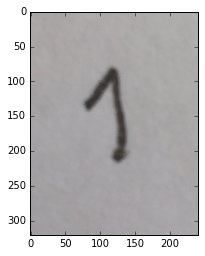

In [12]:
images = get_images(datapath)
show(images, d)

(200, 150, 3)


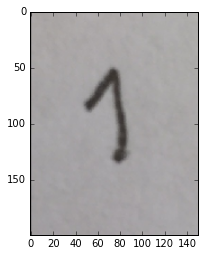

In [13]:
for dig in images:
    images[dig] = resize_image(images[dig], 200)
show(images, d)

(200, 150)


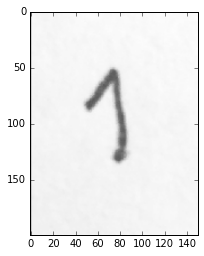

In [14]:
for dig in images:
    images[dig] = to_bw(images[dig])

show(images, d)

(200, 150)


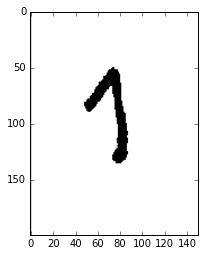

In [15]:
for dig in images:
    images[dig] = gray_threshold(images[dig])

show(images, d)

(87, 40)


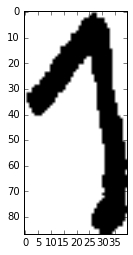

In [16]:
for dig in images:
    images[dig] = trim_border(images[dig])

show(images, d)

(20, 9)


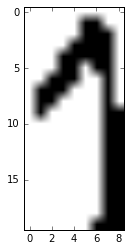

In [17]:
for dig in images:
    images[dig] = resize_image(images[dig], 20)

show(images, d)

(28, 28)


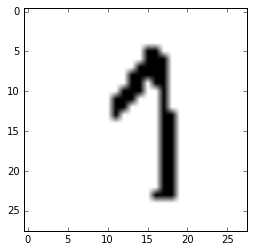

In [18]:
for dig in images:
    images[dig] = pad_image(images[dig], 28)

show(images, d)

(28, 28)


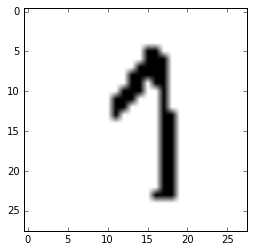

In [19]:
for dig in images:
    images[dig] = gray_threshold(images[dig])

show(images, d)

(28, 28)


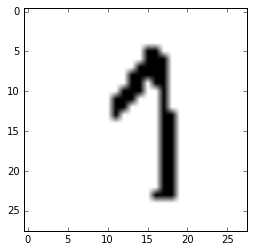

In [20]:
for dig in images:
    images[dig] = shift(images[dig])

show(images, d)

In [21]:
save_images(images, datapath)

saving  own_hand_data/pp_0.jpg (28, 28)
saving  own_hand_data/pp_1.jpg (28, 28)
saving  own_hand_data/pp_2.jpg (28, 28)
saving  own_hand_data/pp_3.jpg (28, 28)
saving  own_hand_data/pp_4.jpg (28, 28)
saving  own_hand_data/pp_5.jpg (28, 28)
saving  own_hand_data/pp_6.jpg (28, 28)
saving  own_hand_data/pp_7.jpg (28, 28)
saving  own_hand_data/pp_8.jpg (28, 28)
saving  own_hand_data/pp_9.jpg (28, 28)
